# Setup

In [123]:
import sys
sys.path.append("../")

In [146]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cv2
from common import plot_helpers
from skimage.segmentation import chan_vese
%matplotlib inline 

In [125]:
colormap = mcolors.LinearSegmentedColormap.from_list(
    "", plt.cm.viridis.colors, N=0xFFFF)

## Load Data

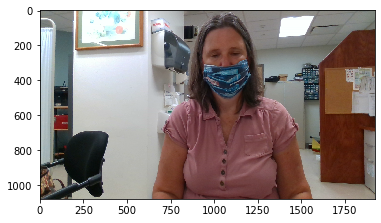

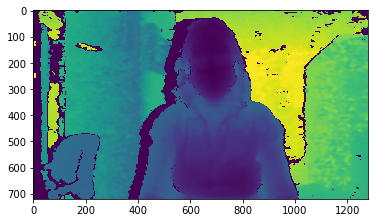

In [169]:
subj='QKZF-SWAL-UJPN'
hand='left'
file_name=f'/home/mjsobrep/Downloads/data/{subj}/target-touch/full_data-vid.hdf5'
cam='upper'
data = h5py.File(file_name, 'r')
color_idx=100
depth_idx=data['vid/lower/color/matched_depth_index'][color_idx]
img=data['vid/lower/color/data'][color_idx]
depth_img_raw=data['vid/lower/depth/data'][depth_idx]
depth_img = plot_helpers.stretch_histogram(depth_img_raw)
depth_img = (colormap(depth_img) * 0xFFFF).astype(np.uint16)[:, :, :3]
depth_img = cv2.cvtColor(depth_img, cv2.COLOR_RGB2BGR)
# convert from 16 to 8 bit
depth_img = cv2.convertScaleAbs(depth_img, alpha=(0xFF/0xFFFF))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_depth_rgb=cv2.cvtColor(depth_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.figure()
plt.imshow(img_depth_rgb)

# Explore Feature Detectors

## Harris

The Harris detector works on one channel, so we need to be in grayscale or black and white

#### RGB Imager

##### Grayscale

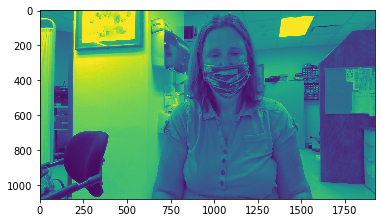

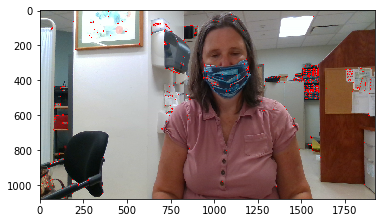

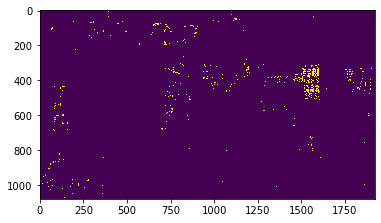

In [127]:
img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(img_grey)

dst = cv2.cornerHarris(img_grey,2,3,0.04)
dst = cv2.dilate(dst,None)
img_w_harris=img_rgb.copy()
img_w_harris[dst>0.01*dst.max()]=[255,0,0]
plt.figure()
plt.imshow(img_w_harris)
plt.figure()
harris_points=np.zeros(img_w_harris.shape[0:2])
harris_points[dst>0.01*dst.max()]=255
plt.figure
plt.imshow(harris_points)

##### Black and White

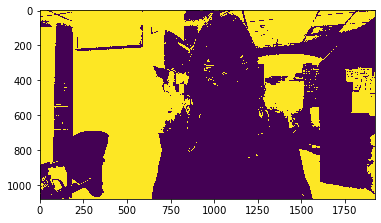

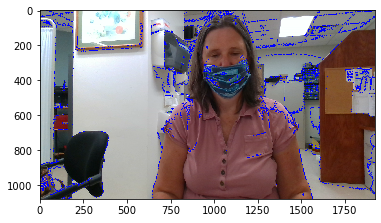

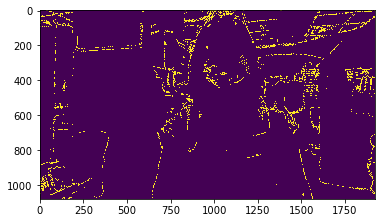

In [145]:
img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(thresh, im_bw) = cv2.threshold(img_grey, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# im_bw = cv2.morphologyEx(im_bw, cv2.MORPH_CLOSE, (9,9))

plt.figure()
plt.imshow(im_bw)

dst = cv2.cornerHarris(im_bw,2,3,0.04)
dst = cv2.dilate(dst,None)
img_w_harris = img_rgb.copy()
img_w_harris[dst>0.01*dst.max()]=[0,0,255]
plt.figure()
plt.imshow(img_w_harris)
plt.figure()
harris_points=np.zeros(img_w_harris.shape[0:2])
harris_points[dst>0.01*dst.max()]=255
plt.figure
plt.imshow(harris_points)

#### Depth Imager

##### stretched detph

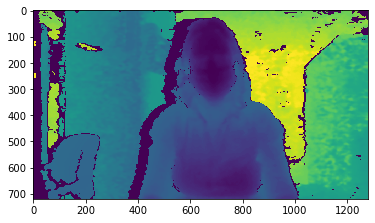

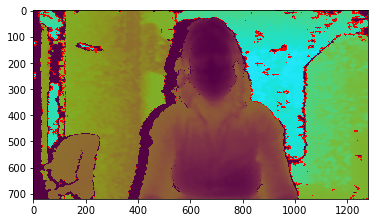

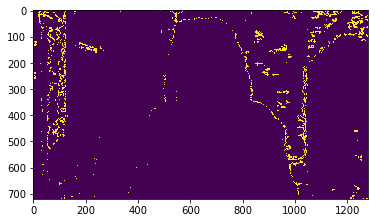

In [129]:
img_d_grey=cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(img_d_grey)

dst = cv2.cornerHarris(img_d_grey,2,3,0.04)
dst = cv2.dilate(dst,None)
img_w_harris = depth_img.copy()
img_w_harris[dst>0.01*dst.max()]=[255, 0,0]
plt.figure()
plt.imshow(img_w_harris)
plt.figure()
harris_points=np.zeros(img_w_harris.shape[0:2])
harris_points[dst>0.01*dst.max()]=255
plt.figure
plt.imshow(harris_points)

##### Black and White

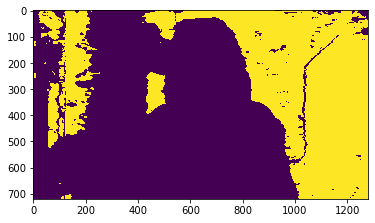

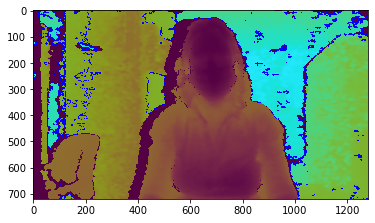

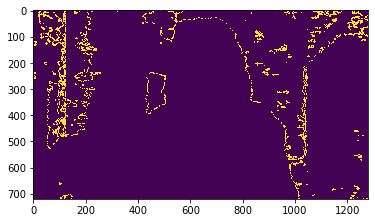

In [130]:
img_d_grey=cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
(thresh, im_d_bw) = cv2.threshold(img_d_grey, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.figure()
plt.imshow(im_d_bw)

dst = cv2.cornerHarris(im_d_bw,2,3,0.04)
dst = cv2.dilate(dst,None)
img_w_harris = depth_img.copy()
img_w_harris[dst>0.01*dst.max()]=[0,0,255]
plt.figure()
plt.imshow(img_w_harris)
plt.figure()
harris_points=np.zeros(img_w_harris.shape[0:2])
harris_points[dst>0.01*dst.max()]=255
plt.figure
plt.imshow(harris_points)

##### Original

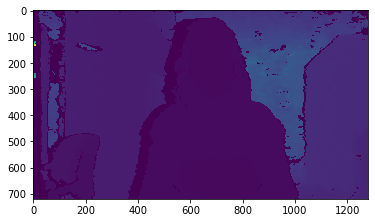

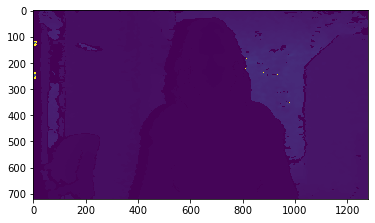

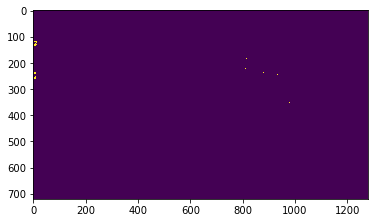

In [131]:
plt.figure()
plt.imshow(depth_img_raw)

dst = cv2.cornerHarris(depth_img_raw.astype('float32'),2,3,0.04)
dst = cv2.dilate(dst,None)
img_w_harris = depth_img_raw.copy()
img_w_harris[dst>0.01*dst.max()]=9999999999
plt.figure()
plt.imshow(img_w_harris)
plt.figure()
harris_points=np.zeros(img_w_harris.shape[0:2])
harris_points[dst>0.01*dst.max()]=255
plt.figure
plt.imshow(harris_points)

## SIFT

In [132]:
sift = cv2.SIFT_create()


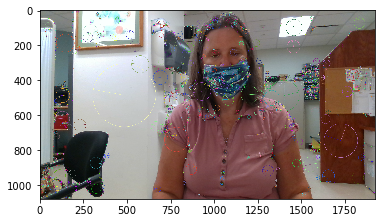

In [138]:
kp1, des1 = sift.detectAndCompute(img_rgb,None)
plt.imshow(cv2.drawKeypoints(img_rgb, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

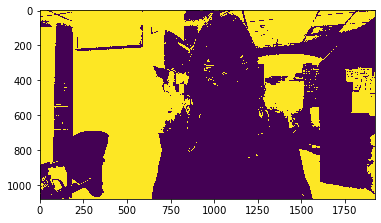

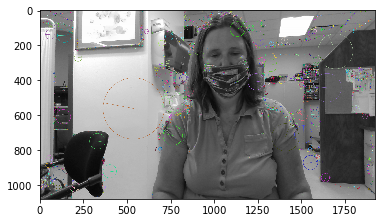

In [134]:
kp1, des1 = sift.detectAndCompute(im_bw,None)
plt.figure()
plt.imshow(im_bw)
plt.figure()
plt.imshow(cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

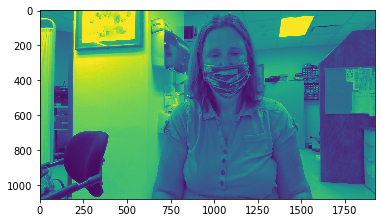

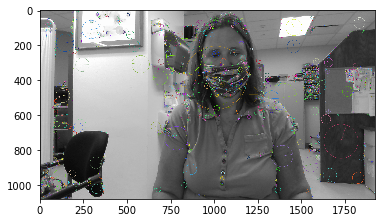

In [135]:
img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(img_grey)
kp1, des1 = sift.detectAndCompute(img_grey,None)
plt.figure()
plt.imshow(cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

### Segmentation

## Multiple image

In [215]:
# https://pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

Text(0.5, 1.0, 'Color 9 depth image median - canny')

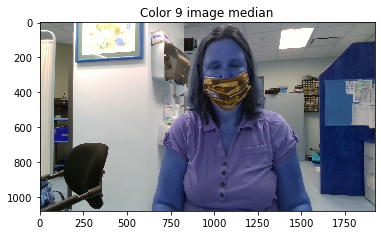

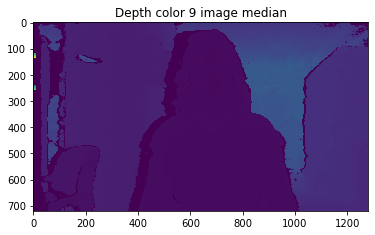

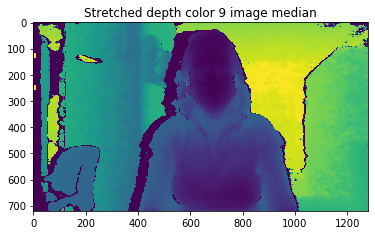

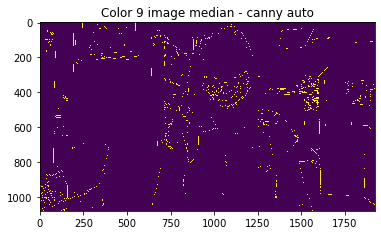

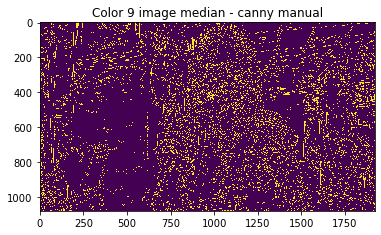

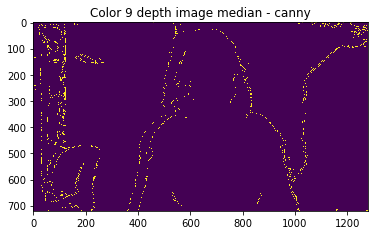

In [230]:
depth_idx=data['vid/lower/color/matched_depth_index'][color_idx]
img_stacked=data['vid/lower/color/data'][color_idx-4:color_idx+4]
img_stacked=np.median(img_stacked, axis=0).astype('uint8')
plt.figure()
plt.imshow(img_stacked)
plt.title('Color 9 image median')

depth_img_stacked=data['vid/lower/depth/data'][depth_idx-4:depth_idx+4]
depth_img_stacked=np.median(depth_img_stacked, axis=0).astype('uint16')
plt.figure()
plt.imshow(depth_img_stacked)
plt.title('Depth color 9 image median')

depth_img_stacked=plot_helpers.stretch_histogram(depth_img_stacked)
depth_img_stacked=cv2.convertScaleAbs(depth_img_stacked, alpha=(0xFF/0xFFFF))
plt.figure()
plt.imshow(depth_img_stacked)
plt.title('Stretched depth color 9 image median')

img_stacked_gray = cv2.cvtColor(img_stacked, cv2.COLOR_BGR2GRAY)
img_stacked_smooth=cv2.GaussianBlur(img_stacked_gray,(3,3),0)
img_stacked_canny=auto_canny(img_stacked_smooth)
plt.figure()
plt.imshow(img_stacked_canny)
plt.title('Color 9 image median - canny auto')

img_stacked_gray = cv2.cvtColor(img_stacked, cv2.COLOR_BGR2GRAY)
img_stacked_smooth=cv2.GaussianBlur(img_stacked_gray,(3,3),0)
img_stacked_canny=cv2.Canny(img_stacked_smooth, 10, 3)
plt.figure()
plt.imshow(img_stacked_canny)
plt.title('Color 9 image median - canny manual')

depth_img_stacked_smooth=cv2.GaussianBlur(depth_img_stacked,(3,3),0)
depth_img_stacked_canny=auto_canny(depth_img_stacked_smooth)
plt.figure()
plt.imshow(depth_img_stacked_canny)
plt.title('Color 9 depth image median - canny')

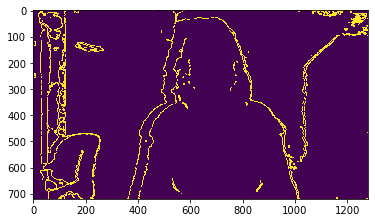

In [236]:

plt.imshow(cv2.dilate(depth_img_stacked_canny,None))

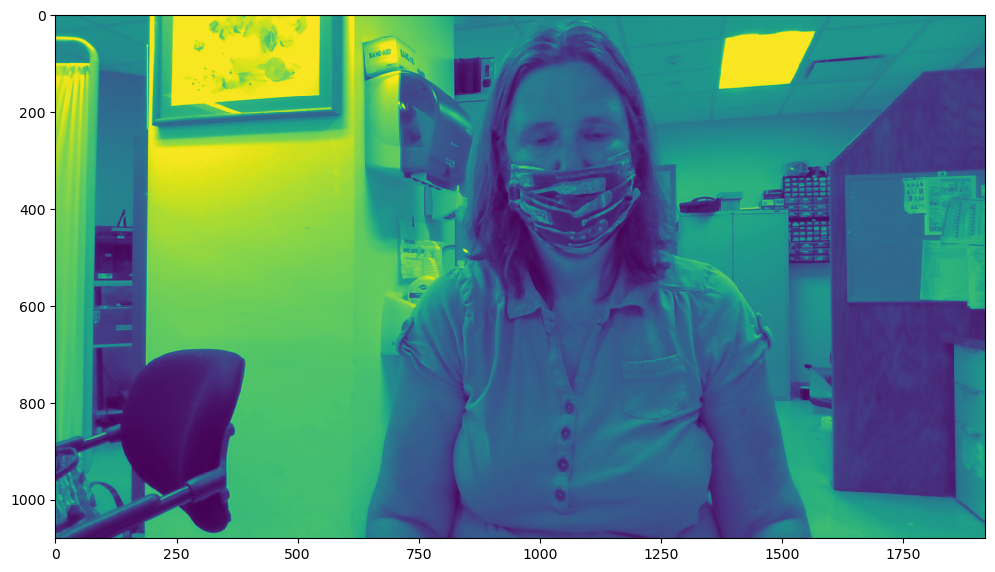

In [225]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img_stacked_smooth)

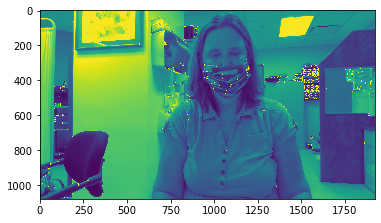

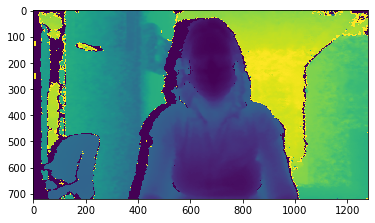

In [200]:
img_grey=cv2.cvtColor(img_stacked, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(img_grey,2,3,0.04)
dst = cv2.dilate(dst,None)
img_w_harris = img_grey.copy()
img_w_harris[dst>0.01*dst.max()]=255
plt.imshow(img_w_harris)

plt.figure()
dst = cv2.cornerHarris(depth_img_stacked,2,3,0.04)
dst = cv2.dilate(dst,None)
img_w_harris = depth_img_stacked.copy()
img_w_harris[dst>0.01*dst.max()]=255
plt.imshow(img_w_harris)

In [195]:
np.where(dst>0.01*dst.max())

(array([119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120,
        120, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122,
        122, 122, 122, 122, 123, 123, 123, 124, 124, 124, 134, 134, 134,
        134, 134, 134, 134, 134, 135, 135, 135, 135, 135, 135, 135, 135,
        136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137,
        137, 137, 137, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242,
        242, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244,
        244, 257, 257, 257, 257, 257, 257, 257, 257, 258, 258, 258, 258,
        258, 258, 258, 258, 259, 259, 259, 259, 259, 259, 259, 259, 260,
        260, 260, 260, 260, 260, 260, 260]),
 array([ 4,  5,  6,  9, 10, 11,  3,  4,  5,  6,  9, 10, 11, 12,  3,  4,  5,
         6,  9, 10, 11, 12,  3,  4,  5,  6,  9, 10, 11, 12,  9, 10, 11,  9,
        10, 11,  2,  3,  4,  5,  8,  9, 10, 11,  2,  3,  4,  5,  8,  9, 10,
        11,  2,  3,  4,  5,  8,  9, 10, 11,  2,  3,  4,  5,  8,  9, 10

# Registration

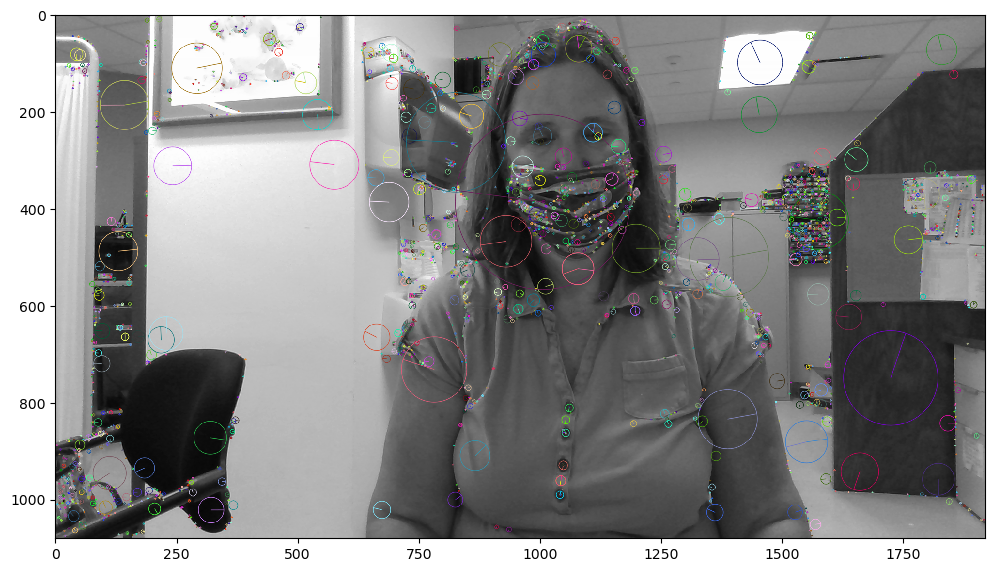

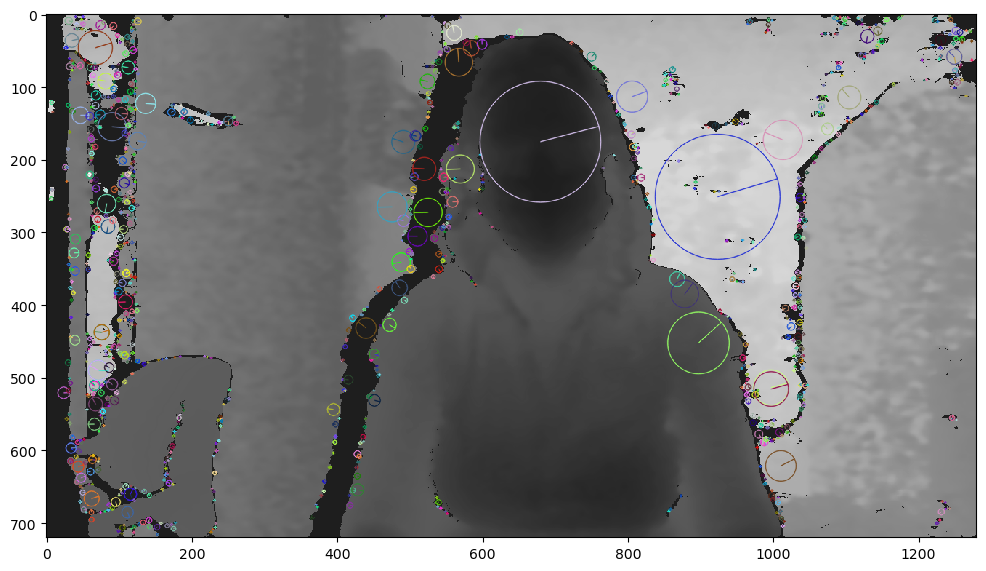

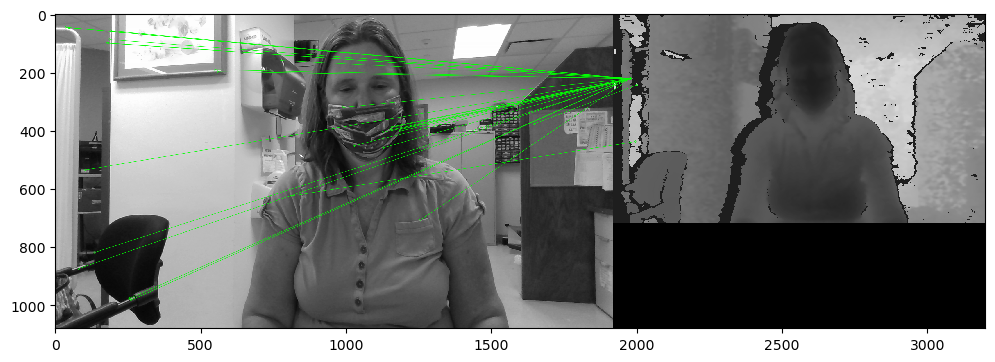

In [136]:
# https://bcmi.sjtu.edu.cn/~zhengweilong/pdf/CE86810.pdf
# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
# https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

MIN_MATCH_COUNT = 10

img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img1=cv2.medianBlur(img1,5)
# img1=cv2.GaussianBlur(img1,(3,3),0)
# img1=cv2.Canny(img1, 200, 10, 3)
img2=cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
# img2=cv2.medianBlur(img2,5)
# img2=cv2.dilate(img2,None)
# img2=cv2.Canny(img2, 200, 10, 3)

# img2=cv2.Canny(img2, 100, 100)

kp1=cv2.cornerHarris(img1,2,3,0.04)
kp2=cv2.cornerHarris(img2,2,3,0.04)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# des1 = sift.compute(img1, np.array(np.where(kp1>0.01*kp1.max())).T)
# des2 = sift.compute(img2, np.array(np.where(kp2>0.01*kp1.max())).T)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img3, 'gray')